This notebook follows the lecture of Andrej Karpathy https://www.youtube.com/watch?v=TCH_1BHY58I
As it was primarily primarily intended as a course notebook, the code may appear unstructured
A more structured version is in the exercise notebook

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [49]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

# for w in words[:5]: # illustration
for w in words: # using the full set now
    
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [50]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [131]:
# construct training, dev, testing datasets
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
    
#         print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27,2))  # 27 characters cramped into a two-dimentional space
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C # input to F.one_hot should be a tensor, not integer (equivalent to C[5])

In [13]:
# C[torch.tensor([5,6,7, 7])] # This works as well
emb = C[X] # our embedding
emb.shape

torch.Size([32, 3, 2])

In [14]:
W1 = torch.randn(6, 100) # weights. 6 - 3*2, 100 - arbitruary chosen number of neurons
b1 = torch.randn(100) # bias

In [19]:
# we cannot do emb @ W1 + b1 because dimensions do not match. We need to concatenate dimensions
# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape # works but not scalable
# torch.cat(torch.unbind(emb, 1), 1).shape
# But, there is a significantly better way to do this - .view() operation
# emb.view(32, 6)
# h = emb.view(emb.shape[0], 6) @ W1 + b1
# emb.view is very efficient because of the way tensors are designed in pytorch. There is an attribute emb.storage()
# which is how tensors are stored. This is a simple sequence of elements.
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # -1 - pytorch will infer that, if the second number is 6, the first must be 32 
h

tensor([[ 0.9732, -0.8976, -0.9986,  ...,  1.0000, -0.8131,  1.0000],
        [ 0.8721, -0.7023, -0.9789,  ...,  1.0000, -0.1928,  1.0000],
        [ 0.9040,  0.4697, -0.3609,  ...,  1.0000, -0.9639,  0.9982],
        ...,
        [-0.2085,  0.5912,  0.7508,  ...,  0.9998,  0.1236,  0.9991],
        [-0.9767,  0.5080,  0.9949,  ...,  0.9972,  0.7536,  0.9997],
        [-0.4748,  0.1084,  0.9696,  ...,  0.9835, -0.8876,  0.9992]])

In [20]:
W2 = torch.randn((100, 27)) # 100 inputs, 27 outputs
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [30]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [31]:
prob[5].sum()

tensor(1.0000)

In [33]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.6987)

In [177]:
# --------------------- better organization ----------------
g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((27,2), generator=g)
# W1 = torch.randn((6, 100), generator=g) # weights. 6 - 3*2, 100 - arbitruary chosen number of neurons
# b1 = torch.randn(100, generator=g)
# W2 = torch.randn((100, 27), generator=g) # 100 inputs, 27 outputs

# increasing the size of the hidden layer
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 300), generator=g) # weights. 6 - 3*2
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g) # 100 inputs, 27 outputs

# increasing the size of embeddings
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g) # weights. 30 - 3*10,
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) # 100 inputs, 27 outputs


b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [178]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [179]:
for p in parameters:
    p.requires_grad = True

In [180]:
# exponential learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [181]:
    lri = []
    lossi = []
    stepi = []

In [190]:

for i in range(200000):
    
    # minibatch construct
#     ix = torch.randint(0, X.shape[0], (32,))
    ix = torch.randint(0, Xtr.shape[0], (32,)) # using only the training dataset
    
    # forward path
#     emb = C[X] # (32, 3,2) 
#     emb = C[X[ix]] # 32 rows, not all 228,000 rows of X
    emb = C[Xtr[ix]] # using only the training dataset
#     h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    loss = F.cross_entropy(logits, Ytr[ix]) # using only the training dataset
#     loss = F.cross_entropy(logits, Y[ix]) # this gives exactly the same result as the three lines above
#     print(loss.item())
    # F.cross_entropy is a lot more efficient memory-wise (it doesn't use memory), backward-wise (because some operations are
    # clustered so no need for intermediate grads). It also is numerically well-behaved

    # backward path
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
#     lr = lrs[i]
#     lr = 0.01 # when the total loss sort of plateaus, we reduce the learning rate
    lr = 0.1 if i < 100000 else 0.01
    
    for p in parameters:
#         p.data += -10 * p.grad
        p.data += -lr * p.grad
    
#     lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
    # how to determine a reasonable learning rate
    # 0.001 - a good low range estimation. Loss sort of decreases but slowly
    # 1 - sort of upper range

# print(loss.item())

# it's much better to have an approximate gradient and make more steps than to have an exact gradient and make fewer steps

In [184]:
print(loss.item())

2.5680809020996094


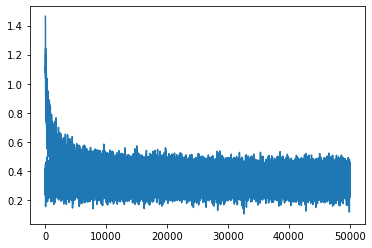

In [194]:
plt.plot(stepi, lossi)

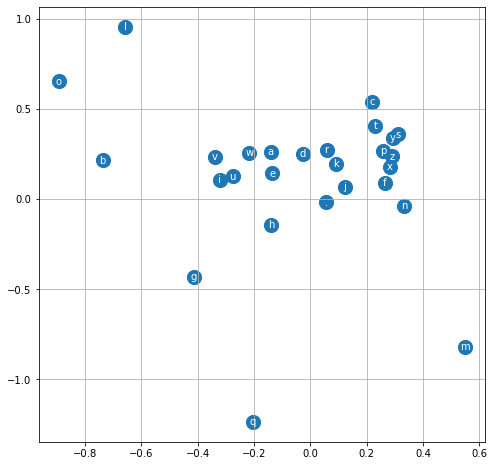

In [191]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')
# vowels are clustered together. q is separate, '.' is separate

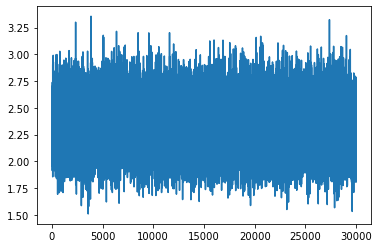

In [165]:
plt.plot(stepi, lossi)

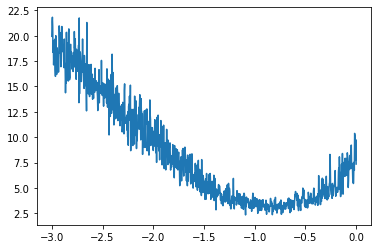

In [118]:
plt.plot(lri, lossi)
# the conclusion is that 0.1 was a good learning rate

In [192]:
# loss for the total set
# emb = C[X[ix]] # 32 rows, not all 228,000 rows of X
emb = C[Xdev] # using the dev set to evaluate the loss
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
# loss = F.cross_entropy(logits, Y[ix])
loss = F.cross_entropy(logits, Ydev) # usind the dev set to evaluate the loss
print(loss.item())

2.180654287338257


In [193]:
# loss for the training set
emb = C[Xtr] # using the tr set to evaluate the loss
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # usind the tr set to evaluate the loss
print(loss.item())
# the losses on the dev set (the model did not see the dev set) and the training set are very similar
# This means that we are not overfitting
# This actually means that we are underfitting because the NN is very small. 
# By increasing the size of the NN, we should get a better result
# The easiest way to do this is to increase the size of the hidden layer

2.1530563831329346


In [61]:
# Illustration of numerical efficientcy of F.cross_entropy
# this will give an error because exp(100) is a too large number
# logits = torch.tensor([-100, -3, 0, 100])
# counts = logits.exp()
# probs = counts / counts.sum()
# probs

# Because there is exp(), you can off-set logits by any number. Pytorch does exactly that

In [62]:
# calculation takes quite a lot of time
# this is address by randomly selecting a sub-set of data and iterating forward and backward using this sub-set

In [63]:
torch.randint(0, X.shape[0], (32,))

tensor([172793, 222629,  76913, 165858, 154040, 138890, 204597,  59472,  91288,
          6224, 165711,  19969,  62980,  54382, 113232,  71451, 118010, 106123,
        123850,  15288, 216911,   2773, 208086, 103431,  10615, 141298, 139657,
        126912,  31569, 190011,  97680,  84125])

In [ ]:
# If we get a lot of parameters, we risk overfitting
# training split (train parameters), 
# dev/validation split (train hyperparameters (size of hidden layer, etc)), test split (test). 80%, 10%, 10%
# you are only allowed to calculate the loss on the test set very-very sparingly, otherwise we overfit

In [202]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 100)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

julizi.
perrey.
fer.
rahses.
kam.
chardish.
jeles.
caraa.
kani.
aydeely.
refief.
tha.
retgeimberon.
farien.
almetey.
ashan.
tre.
harina.
wille.
son.
